## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [59]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [60]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [61]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [62]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [63]:
len(df[(df['converted']==1)]) / len(df) * 100

11.96591935560551

e. The number of times the `new_page` and `treatment` don't line up.

In [64]:
len(df[(df['group']=='treatment')&(df['landing_page']=='old_page') | \
       (df['group']=='control')&(df['landing_page']=='new_page')])

3893

f. Do any of the rows have missing values?

In [65]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [66]:
df2 = df.drop(df[(df['group']=='treatment')&(df['landing_page']=='old_page') | \
             (df['group']=='control')&(df['landing_page']=='new_page')].index)

In [67]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [68]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [69]:
df2[(df2['user_id'].duplicated()==True)][['user_id']]

,user_id
2893,773192


c. What is the row information for the repeat **user_id**? 

In [70]:
df2[(df2['user_id'].duplicated()==True)]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [71]:
df2.drop_duplicates(inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [72]:
df2.loc[df2['converted']==1].user_id.nunique() / df2.user_id.nunique()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [73]:
df2.loc[(df2['group']=='control') & (df2['converted']==1)].user_id.nunique() / \
df2[(df2['group']=='control')].user_id.nunique()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [74]:
df2.loc[(df2['group']=='treatment') & (df2['converted']==1)].user_id.nunique() / \
df2[(df2['group']=='treatment')].user_id.nunique()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [75]:
df2.loc[df2['landing_page']=='new_page'].user_id.nunique() / df2.user_id.nunique()

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

There's a very similar conversion probability for both the treatment group (11.88%) and the control group (12.04%) which indicates there isn't much of an effect by using the new page. Furthermore, since there's only an 11.96% chance that an individual will convert regardless of the page they receive, there isn't sufficient evidence to say that the new page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null: The new page has a conversion rate that less than or equal to that of the old page. 
$$H_0: p_{new} <= p_{old}$$

Alternative: The new page has a conversion rate that is greater than that of the old page. 
$$H_1: p_{new} > p_{old}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**. Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null. Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [76]:
# since the success rate is equal regardless of the page
# a and b will be the same
df2.converted.mean()

0.11959667567149027

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [77]:
df2.converted.mean()

0.11959667567149027

c. What is $n_{new}$?

In [78]:
n_new = len(df2[df2['landing_page']=='new_page'])
n_new

145311

d. What is $n_{old}$?

In [79]:
n_old = len(df2[df2['landing_page']=='old_page'])
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [80]:
new_page_converted = np.random.choice([0,1], 
                                      n_new, 
                                      p=(1-(df2.converted.mean()), df2.converted.mean()))

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [81]:
old_page_converted = np.random.choice([0,1], 
                                      n_old, 
                                      p=(1-(df2.converted.mean()), df2.converted.mean()))

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [82]:
# Compute the observed difference 
obs_diff = new_page_converted.mean() - old_page_converted.mean()

obs_diff

3.8609591027985446e-05

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [83]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0,1], 
                                          n_new, 
                                          p=(1-(df2.converted.mean()), df2.converted.mean()))
    old_page_converted = np.random.choice([0,1], 
                                          n_old, 
                                          p=(1-(df2.converted.mean()), df2.converted.mean()))
    
    obs_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(obs_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

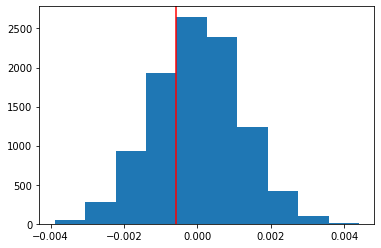

In [84]:
plt.hist(p_diffs)
plt.axvline(obs_diff, c='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [85]:
# Compute p-value
(p_diffs > obs_diff).mean()

0.6871

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The observed difference in proportions is known as the p-value. The p-value is the proportion of values in the null distribution that were greater than our observed difference. Since the p-value is larger than alpha (0.05) it's likely that our statistic is from the null. Therefore we fail to reject the null hypothesis and there is no evidence of a difference between the new and old pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [86]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

convert_old = len(df2.loc[(df2['landing_page']=='old_page') & (df2['converted']==1)])
convert_new = len(df2.loc[(df2['landing_page']=='new_page') & (df2['converted']==1)])

n_old = len(df2[df2['landing_page']=='old_page'])
n_new = len(df2[df2['landing_page']=='new_page'])

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [87]:
stat, pval = proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
stat, pval

(-1.3116075339133115, 0.905173705140591)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

This z-score tell how far a point lies from mean of a distribution. Since the z-score is below 1.5, the conversion rate for the new page is less than 95% of the old page, which re-enforces the fact that we cannot reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [88]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [89]:
# Create dummy variable columns 
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2 = df2.drop('old_page', axis=1)

In [90]:
# Create the intercept 
df2['intercept'] = 1

In [91]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [92]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit(method='bfgs')
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Fri, 22 May 2020   Pseudo R-squ.:               8.084e-06
Time:                        10:50:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0149      0.011     -1.305      0.192      -0.037       0.007
==============================================================================
"""

In [95]:
# exponentiate the coefficients in order to interpret them
np.exp(-0.0149)

0.9852104557227469

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

After exponentiating the ab_page coefficient, we see that an individual is 99 times as likely to convert if they are given the new page, holding all else constant. The p-value is greater than 0.05, meaning it is not statistically significant.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

Since the p-value associated with ab_page is greater than 0.05, we can conclude it is not statistically significant in predicting whether an individual will convert or not. In Part II, the null and alternative hypothesis were testing whether the new page had a higher conversion rate, whereas in Part III the null and alternative hypothesis are testing whether the conversion rate between the new and old page are equal.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It is useful to consider other factors that might make your predictions more accurate. However, the more terms you add to your regression model the higher the chance of multicollinearity.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [48]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,new_page,ab_page,intercept
user_id,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1


In [49]:
### Create the necessary dummy variables
df_new[['US', 'UK', 'CA']] = pd.get_dummies(df_new['country'])
df_new = df_new.drop('CA', axis=1)
df_new.head()

,country,timestamp,group,landing_page,converted,new_page,ab_page,intercept,US,UK
user_id,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1,0,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1,0,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,0,0,1,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1,0,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1,0,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [51]:
# Create additional interaction columns
df_new['us_page'] = df_new['ab_page'] * df_new['US']
df_new['uk_page'] = df_new['ab_page'] * df_new['UK']
df_new.head()

,country,timestamp,group,landing_page,converted,new_page,ab_page,intercept,US,UK,us_page,uk_page
user_id,,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1,0,0,0,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1,0,0,0,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,0,0,1,0,0,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1,0,0,0,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1,0,0,0,0


In [52]:
### Fit Your Linear Model And Obtain the Results
logit_mod_cntry = sm.Logit(df_new['converted'], df_new[['intercept', 
                                                        'ab_page', 
                                                        'US', 
                                                        'UK',
                                                        'us_page',
                                                        'uk_page']])

results = logit_mod_cntry.fit(method='bfgs')
results.summary()

         Current function value: 0.366110
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            5
Date:                Fri, 22 May 2020   Pseudo R-squ.:               2.807e-05
Time:                        10:27:42   Log-Likelihood:            -1.0639e+05
converged:                      False   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.3089
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9829      0.010   -206.252      0.000      -2.002      -1.964
ab_page       -0.0300      0.014     -2.198      0.028      -0.057      -0.003
US            -0.0404      0.038     -1.065      0.287      -0.115       0.034
UK            -0.0073      0.019     -0.391      0.696      -0.044       0.029
us_page        0.0112      0.054      0.208      0.835      -0.094       0.116
uk_page        0.0406      0.027      1.527      0.127      -0.012       0.093
==============================================================================
"""

In [54]:
# exponentiate the coefficients in order to interpret them
np.exp(-0.0404), np.exp(-0.0073), np.exp(0.0112), np.exp(0.0406)

(0.96040520022957, 0.9927265802819868, 1.011262954811771, 1.0414354480403178)

<a id='conclusions'></a>
## Conclusions
- An individual from the US is 96% more likely to convert than an individual from the UK or CA. 
- An individual from the UK is 99% more likely to convert than an individual from the US or CA.
- Since all of the country related p-values are greater than 0.05, they are not statistically significant and we fail to reject the null hypothesis.